In [1]:
import pydriller
import numpy as np
import matplotlib.pyplot as plt

In [2]:
elastic_path = "C:\\Users\\luist\\OneDrive\\Escritorio\\SOSY-SE-ASSIGNMENT\\elastic\\elasticsearch"

In [3]:
repo = pydriller.Repository(elastic_path, from_tag="v1.0.0", to_tag="v1.1.0")

In [4]:
# we create the dictionary author => number of modified files

authors_nmodif_dictionary = {}
for c in repo.traverse_commits():
    for mf in c.modified_files:
        if mf.new_path is not None:
            if mf.new_path.endswith('java'):
                if c.author.name not in authors_nmodif_dictionary:
                    authors_nmodif_dictionary[c.author.name] = 1
                else:
                    authors_nmodif_dictionary[c.author.name] += 1      
authors_nmodif_dictionary = {k: v for k, v in sorted(authors_nmodif_dictionary.items(), key=lambda item: item[1], reverse=True)}

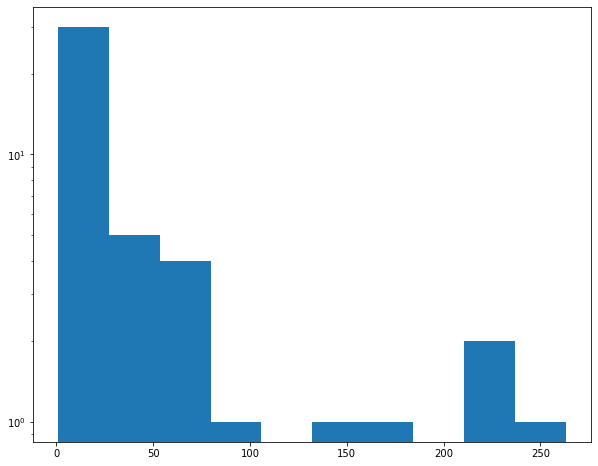

In [50]:
# visualization: number of authors (y) who modified n files (x)

plt.figure(figsize=(10,8))
plt.hist(list(authors_nmodif_dictionary.values()), bins=10)
plt.yscale('log')
plt.show()

In [6]:
# we create the dictionary file => number of authors

file_author_dictionary = {}
for c in repo.traverse_commits():
    author = c.author.name
    for mf in c.modified_files:
        if mf.new_path is not None:
            if mf.new_path.endswith('java'):
                if mf.new_path not in file_author_dictionary:
                    file_author_dictionary[mf.new_path] = set([author])
                else:
                    file_author_dictionary[mf.new_path].add(author)
file_author_dictionary = {k: len(v) for k, v in file_author_dictionary.items()}
file_author_dictionary = {k: v for k, v in sorted(file_author_dictionary.items(), key=lambda item: item[1], reverse=True)}

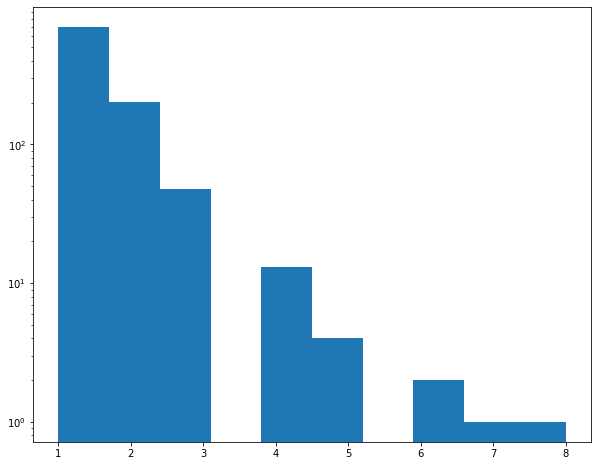

In [48]:
# visualization: number files (y) with n authors (x)

plt.figure(figsize=(10,8))
plt.hist(list(file_author_dictionary.values()), bins=10)
plt.yscale('log')
plt.show()

In [29]:
from enum import Enum

class Modification(Enum):
    ADDED = "Lines added"
    REMOVED = "Lines removed"
    TOTAL = "Lines added + lines removed"
    DIFF = "Lines added - lines removed"

In [51]:
def count_lines(operation, file):
    if operation == Modification.ADDED:
        return file.added_lines
    elif operation == Modification.REMOVED:
        return file.deleted_lines
    elif operation == Modification.DIFF:
        return file.added_lines - file.deleted_lines
    elif operation == Modification.TOTAL:
        return file.added_lines + file.deleted_lines
    else:
        raise "Invalid operation"
        
# the following situations can happen
# 1 - a file is added --> old path = None
# 2 - a file is deleted --> new path = None
# 3 - a file is moved --> old != new (we need to count both)
# 4 - otherwise old == new
        
def get_modification_loc(operation, filepath):
    res = {}
    for c in repo.traverse_commits():
        author = c.author.name
        for mf in c.modified_files:
            # situation 1
            if mf.old_path is None:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # situation 2
            elif mf.new_path is None:
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
            # situation 3
            elif mf.old_path != mf.new_path:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
                if mf.old_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf) 
            # situation 4
            else:
                if mf.new_path.startswith(filepath):
                    if author not in res:
                        res[author] = count_lines(operation, mf)
                    else:
                        res[author] += count_lines(operation, mf)
                            
    return {k: v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=True)}

In [52]:
filepath = "src\\main\\java\\org\\elasticsearch\\search"

total_modification = get_modification_loc(Modification.TOTAL, filepath)

In [53]:
total_modification

{'uboness': 4285,
 'Zachary Tong': 2297,
 'Adrien Grand': 2193,
 'markharwood': 1965,
 'Simon Willnauer': 1743,
 'Florian Schilling': 1702,
 'javanna': 617,
 'Nik Everett': 338,
 'Lee Hinman': 269,
 'Martijn van Groningen': 93,
 'Alexander Reelsen': 79,
 'Luca Cavanna': 69,
 'jayesh.modi': 24,
 'Nils Dijk': 14,
 'Britta Weber': 2}

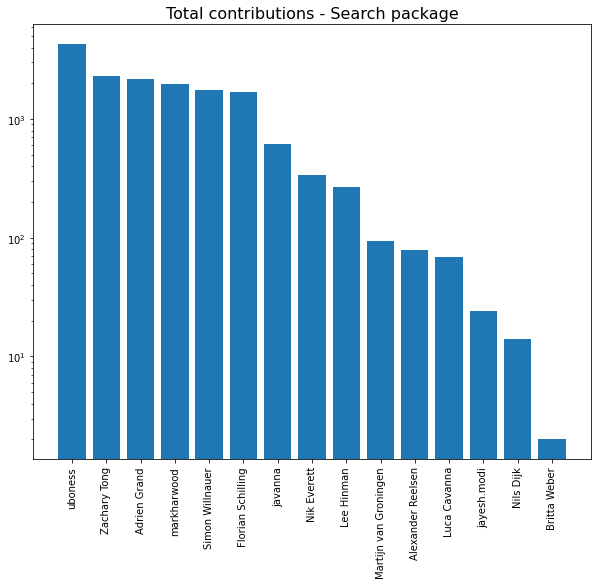

In [54]:
plt.figure(figsize=(10,8))
plt.title('Total contributions - Search package', fontsize=16)
plt.bar(total_modification.keys(), total_modification.values())
plt.yscale('log')
plt.xticks(rotation='vertical')
plt.show()